In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


https://drive.google.com/file/d/1C9IcfZK7rtJU23UWNy7kr3czarITcB1s

In [3]:
!gdown --id 1C9IcfZK7rtJU23UWNy7kr3czarITcB1s

Downloading...
From: https://drive.google.com/uc?id=1C9IcfZK7rtJU23UWNy7kr3czarITcB1s
To: /content/cookie_cats.csv
2.80MB [00:00, 85.9MB/s]


In [4]:
df = pd.read_csv('/content/cookie_cats.csv')

**Описание данных** \

*  userid - уникальный идентификатор пользователя  
*  version - в какую группу был помещен пользователь в контрольную (gate_30 на 30 уровне игры) или в тестовую (gate_40 на 40 уровне игры) \
*  sum_gamerounds - количество сыгранных раундов после установки игры \
*  retention_1 - удержание 1ого дня \
*  retenrion_7 - удержание 7ого дня

После установки игрок был случайно помещен в группу gate_30 либо gate_40


In [5]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [6]:
df.shape

(90189, 5)

In [7]:
df['userid'].nunique()

90189

In [8]:
df.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17,52.456264,256.716423,49854
gate_40,45489,16,51.298776,103.294416,2640


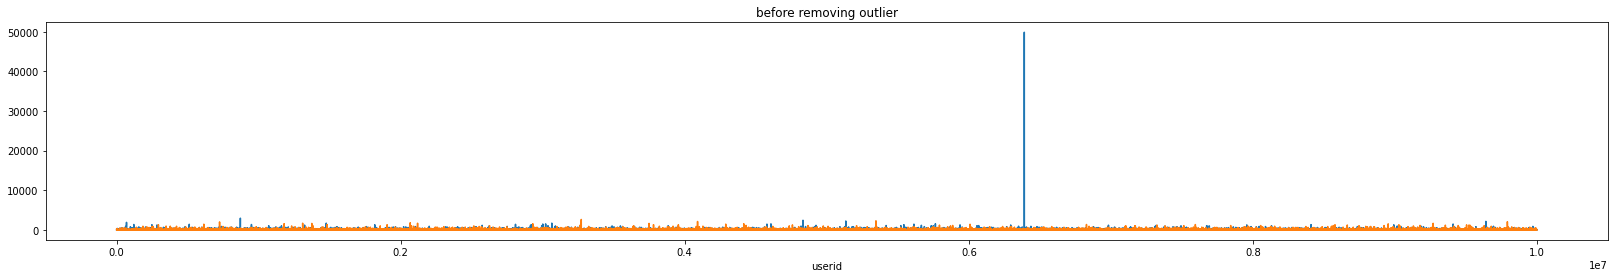

In [9]:
plt.figure(figsize=(28,4))
df[df['version'] == 'gate_30'].set_index('userid')['sum_gamerounds'].plot(title='before removing outlier')
df[df['version'] == 'gate_40'].set_index('userid')['sum_gamerounds'].plot()

Из полученных значений видно, что в данных имеются выбросы

In [10]:
df.drop(df.nlargest(1, 'sum_gamerounds').index, inplace=True)

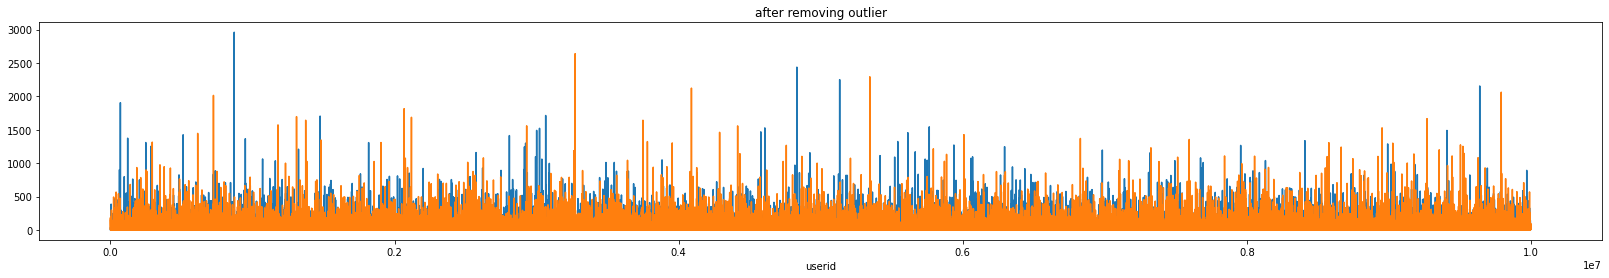

In [11]:
plt.figure(figsize=(28,4))
df[df['version'] == 'gate_30'].set_index('userid')['sum_gamerounds'].plot(title='after removing outlier')
df[df['version'] == 'gate_40'].set_index('userid')['sum_gamerounds'].plot()

In [12]:
df.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44699,17,51.342111,102.057598,2961
gate_40,45489,16,51.298776,103.294416,2640


In [13]:
df.groupby('sum_gamerounds')['userid'].count()

sum_gamerounds
0       3994
1       5538
2       4606
3       3958
4       3629
        ... 
2251       1
2294       1
2438       1
2640       1
2961       1
Name: userid, Length: 941, dtype: int64

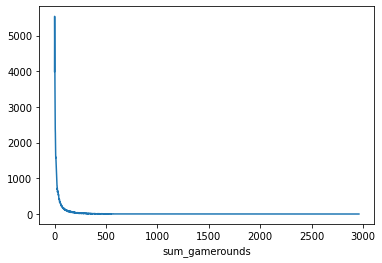

In [14]:
df.groupby('sum_gamerounds')['userid'].count().plot()

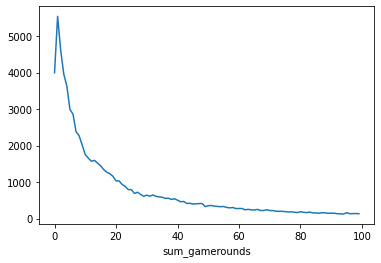

In [15]:
df[df['sum_gamerounds'] < 100].groupby('sum_gamerounds')['userid'].count().plot()

3994 игрока ни разу не заходили в игру после установки

In [16]:
round(df['retention_1'].sum() / df.shape[0] *100, 2)

44.52

In [17]:
round(df['retention_7'].sum() / df.shape[0] *100, 2)

18.61

Удрержание 1ого дня равно 44.52 % \
Удрержание 7ого дня равно 18.61 % \

In [18]:
df.groupby('version')[['retention_1', 'retention_7']].mean()

,retention_1,retention_7
version,,
gate_30,0.448198,0.190183
gate_40,0.442283,0.182000


Удержание 1ого и 7ого дня для каждой группы


# AB тест с помощью Bootstrap

Для удержания 1ого дня:

In [1]:
from tqdm.notebook import tqdm

  0%|          | 0/1000 [00:00<?, ?it/s]

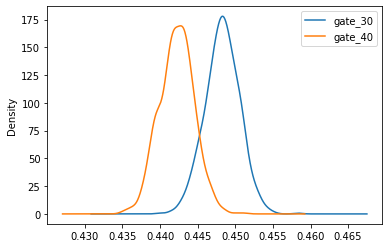

In [75]:
boot_1d = []
for i in tqdm(range(1000)):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
boot_1d = pd.DataFrame(boot_1d, columns=['gate_30', 'gate_40'])
    
boot_1d.plot(kind = 'kde')

In [76]:
boot_1d['diff'] = ((boot_1d['gate_30'] - boot_1d['gate_40'])/boot_1d['gate_40'])* 100

In [77]:
prob_1d = (boot_1d['diff'] > 0 ).mean()

In [78]:
prob_1d

0.969

Вероятность того, что удаержание 1ого дня больше на gate_30 равно 96.9%


**Для удержания 7ого дня:**

  0%|          | 0/1000 [00:00<?, ?it/s]

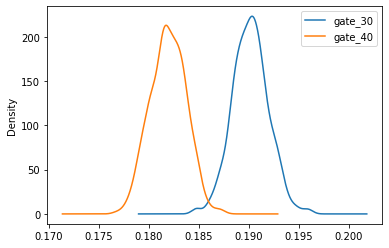

In [85]:
boot_7d = []
for i in tqdm(range(1000)):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
boot_7d = pd.DataFrame(boot_7d, columns=['gate_30', 'gate_40'])

boot_7d.plot(kind = 'kde')

In [86]:
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40'])/boot_7d['gate_40'])* 100

In [87]:
prob_7d = (boot_7d['diff'] > 0 ).mean()

In [88]:
prob_7d

0.999

С вероятностью в 99.9% можем сказать что удержание 7ого дня на gate_30 больше, чем на gate_40

Вывод:\
Если мы хотим сохранить удержание игроков выскоим, в этом случае не стоит менять gate с 30 на 40